## Lab 4.3. 

#### Setup your imports

In [2]:
import pandas as pd 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#### 1. Pull the training set from the newsgroup data
The data has 20 different categories. Try to shrink down to smaller number of groups according to the definition here:
http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

In [3]:
data = fetch_20newsgroups(remove =['headers','footers','quotes'])
# newsgroups_train = fetch_20newsgroups(subset='train', remove =['headers','footers','quotes'])
# newsgroups_test = fetch_20newsgroups(subset='test', remove =['headers','footers','quotes'])

# pick 4 news groups, specify categories, all


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
categories = [
    #'alt.atheism',
    'talk.religion.misc',
    'rec.sport.baseball',
    'comp.sys.mac.hardware',
    #'comp.graphics',
    'sci.space',
]
true_k = len(categories)
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

#### 2. Create the vectorizer 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=.5, max_features=1000,
                                 min_df=2, stop_words='english',
                                 use_idf=True, sublinear_tf=False, 
                                 analyzer = 'word',
                                 token_pattern = '[a-zA-Z]{4,50}',
                            )

X = tfidf.fit_transform(dataset.data)
y = dataset.target

#### 3. Create the Truncated Singular Value Decomposition. 

In [7]:
# SVD does latent semantic analysis then renormalize
svd = TruncatedSVD(300)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

#### 4. Setup your k-means clustering

In [8]:
# We cheat because we know there are 4 clusters
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=30,
                verbose=0)

#### 5. Fit the vectorizer and SVD

In [9]:
X_lsa = lsa.fit_transform(X)

print "Explained variance with LSA"
print svd.explained_variance_ratio_.sum()


Explained variance with LSA
0.689539601633


What are top 50 most useful terms based on article itself? Are those terms similar to the top 50 from step 2? 

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
columns = tfidf.get_feature_names()
new_X = pd.Series(columns)

selector = SelectKBest(f_classif, k=50)
selected_data = selector.fit_transform(X, y)

kbest = new_X[selector.get_support()]
print kbest


5            access
36            apple
59             ball
63         baseball
78            bible
79         biblical
92           braves
117         centris
132          christ
133       christian
134    christianity
135      christians
221            died
226           digex
242           drive
248           earth
301          flight
319            game
320           games
374           henry
424           jesus
426            jews
438            kent
452          koresh
460          launch
464          league
542         mission
551         monitor
554            moon
556        morality
561            nasa
575          newton
602           orbit
620          people
639        pitching
648            play
650          player
651         players
695          quadra
722        religion
723       religious
755            runs
759         sandvik
774          season
792         shuttle
822           space
829         spencer
877            team
889          thanks
995            year


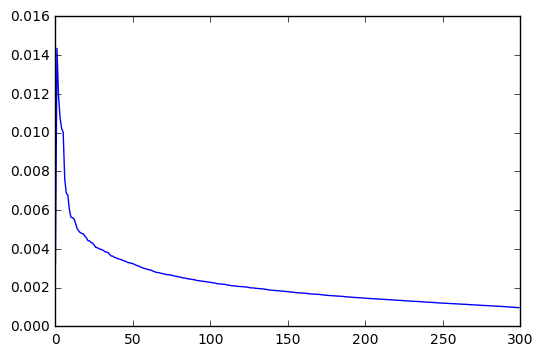

In [11]:
plt.plot(svd.explained_variance_ratio_)
plt.show()

Plot the cummulative variace from the terms. x-axis: number of components; y-axis: cummulative variance. 
Based on the plot, decide how many principle components you need. 

#### 7. Fit the kmeans (Question: in this case, do you recommend running K-means without dimension reduction?)

In [12]:
km.fit(X_lsa)
labels = y

In [13]:
print "Use dimension reduction."

Use dimension reduction.


Print out your centroids. Look at the value for each centroid. Does each centroid represent a news group as expected? 

In [14]:
print "Top terms per cluster:"

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
print categories

for i in range(true_k):
    print "Cluster %d:" % i 
    temp = []
    for ind in order_centroids[i, :10]:
        temp.append(terms[ind])
    print temp


Top terms per cluster:
['talk.religion.misc', 'rec.sport.baseball', 'comp.sys.mac.hardware', 'sci.space']
Cluster 0:
[u'university', u'posting', u'host', u'nntp', u'apple', u'know', u'thanks', u'drive', u'does', u'just']
Cluster 1:
[u'jesus', u'sandvik', u'christian', u'people', u'koresh', u'bible', u'brian', u'kent', u'morality', u'objective']
Cluster 2:
[u'space', u'nasa', u'access', u'henry', u'digex', u'shuttle', u'toronto', u'alaska', u'moon', u'launch']
Cluster 3:
[u'game', u'baseball', u'year', u'team', u'games', u'players', u'runs', u'braves', u'good', u'think']


#### 8. Check the performance of our kmeans

In [15]:
print "Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_)
print "Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_) 
print "V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_) 
print "Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_) 
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_lsa, km.labels_, sample_size=1000) 


Homogeneity: 0.572
Completeness: 0.627
V-measure: 0.598
Adjusted Rand-Index: 0.480
Silhouette Coefficient: 0.022


#### Classification Report

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.choose(km.labels_, [0,3,2,1])

confusion_matrix(y, y_pred)

array([[957,   0,   6,   0],
       [218, 774,   2,   0],
       [289,   4, 690,   4],
       [226,   2,   5, 395]])

In [21]:
print classification_report(y, y_pred)

             precision    recall  f1-score   support

          0       0.57      0.99      0.72       963
          1       0.99      0.78      0.87       994
          2       0.98      0.70      0.82       987
          3       0.99      0.63      0.77       628

avg / total       0.87      0.79      0.80      3572



#### Confusion Matrix. Hint: create a map to translate the label between k-means clustering and the original target (newsgroups_train.target). 

In [ ]:
# Above

#### Note: Repeat the lab with:
- varying values of "k" 
- trying a different way to pick starting centroids ('k-means++' is the default method for centroids). For example, pick one point from each newsgroup. 

In [ ]:
# I really don't think I need to do this part after doing so many different kmeans in project 7